In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stardist.matching import matching

from src.data import FullImageDataset
from src.metrics import calculate_dice, calculate_iou, calculate_map
from src.utils import apply_watershed, map_mask

# Create dataset

In [2]:
batch_size = 50

train_dataset = FullImageDataset(
    '../data/processed/train/img',
    '../data/processed/train/mask',
)

val_dataset = FullImageDataset(
    '../data/processed/val/img',
    '../data/processed/val/mask',
)

test_dataset = FullImageDataset(
    '../data/processed/test/img',
    '../data/processed/test/mask',
)

<tifffile.TiffFile 'otherspecimen_3.tif'> shaped series shape does not match page shape


Succesfully loaded 38 images
Succesfully loaded 4 images
Succesfully loaded 37 images


# Find threshold maximizing dice

In [3]:
def get_dice(threshold, dataset, normalize=True):
    dice = []
    for img, mask in dataset:
        if normalize:
            img = img/np.max(img)
        pred = img > threshold
        dice.append(calculate_dice(mask.astype(bool), pred.astype(bool)))
    return np.mean(dice)

In [4]:
values = []
for threshold in range(100):
    values.append(get_dice(threshold/100, train_dataset, normalize=True))

In [5]:
threshold = np.argmax(values)/100

print(f"train dice: {get_dice(threshold, train_dataset)}")
print(f"val dice: {get_dice(threshold, val_dataset)}")


train dice: 0.9130730966498082
val dice: 0.9004406545984814


# Evaluate model

In [6]:
def predict(image, mask, threshold):
    image /= np.max(image)
    pred = apply_watershed(image[0] > threshold)
    pred = map_mask(mask[0], pred)
    return pred

## Calculate metrics

In [15]:
def evaluate(threshold, dataset):
    metrics = []
    for img, mask in dataset:
        pred = predict(img, mask, threshold)

        mask = np.squeeze(mask)

        metrics.append({
            'dice': calculate_dice(mask, pred),
            'iou': calculate_iou(mask, pred),
            'map': calculate_map(mask, pred),
            })
    return pd.DataFrame(metrics)

In [20]:
results = evaluate(threshold, val_dataset)
results.describe()

,dice,iou,map
count,4.000000,4.000000,4.000000
mean,0.899532,0.819211,0.632102
std,0.040177,0.065863,0.228087
min,0.847080,0.734726,0.362540
25%,0.886202,0.796380,0.536730
50%,0.903214,0.823535,0.624088
75%,0.916544,0.846366,0.719460
max,0.944618,0.895048,0.917693


In [21]:
results = evaluate(threshold, train_dataset)
results.describe()

,dice,iou,map
count,38.000000,38.000000,38.000000
mean,0.898552,0.830451,0.672310
std,0.107172,0.155382,0.236515
min,0.590820,0.419265,0.212680
25%,0.867273,0.765652,0.483654
50%,0.950780,0.906183,0.745298
75%,0.971974,0.945476,0.873623
max,0.982680,0.965950,0.964161


## Plot results

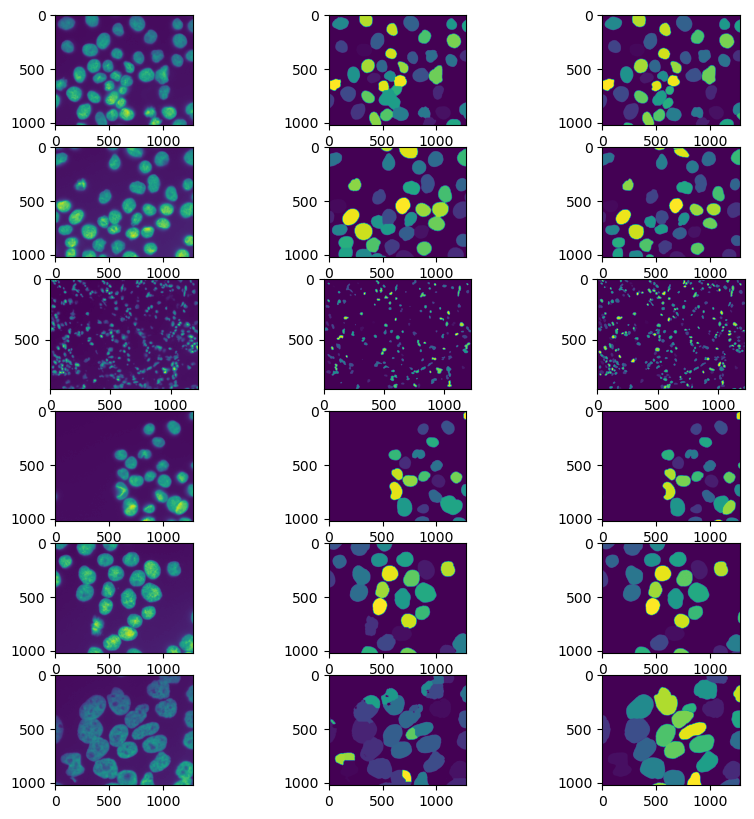

In [24]:
num_rows = 6

img, mask = train_dataset[0]
fig, axes = plt.subplots(num_rows, 3, figsize=(10, 10))

for row in range(num_rows):
    img, mask = train_dataset[row]
    pred = predict(img, mask, threshold)
    axes[row, 0].imshow(img[0])
    axes[row, 1].imshow(pred)
    axes[row, 2].imshow(mask[0])